# AutoGluon Text - Quick Start with Sentiment Analysis

In the following example, we will briefly demonstrate the usage of TextPredictor, and apply it on a sentiment classification dataset.

In [1]:
%matplotlib inline

import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.random.seed(123)

We will use the Stanford Sentiment Treebank ([SST](https://nlp.stanford.edu/sentiment/)) dataset, which consists of movie reviews and their associated sentiment. Given a new movie review, the goal is to predict the sentiment reflected in the text (in this case a **binary classification**, where reviews are labeled as 1 if they convey a positive opinion and labeled as 0 otherwise). Let's first load and look at the data, noting the labels are stored in a column called **label**. Here, for a quick demonstration, we will sample 1000 rows.


In [2]:
from autogluon.core.utils.loaders.load_pd import load
train_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet')
test_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet')
subsample_size = 1000  # subsample data for faster demo, try setting this to larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head(10)

,sentence,label
43787,very pleasing at its best moments,1
16159,", american chai is enough to make you put away...",0
59015,too much like an infomercial for ram dass 's l...,0
5108,a stirring visual sequence,1
67052,cool visual backmasking,1
35938,hard ground,0
49879,"the striking , quietly vulnerable personality ...",1
51591,pan nalin 's exposition is beautiful and myste...,1
56780,wonderfully loopy,1
28518,"most beautiful , evocative",1


The data above happen to be stored in a [Parquet](https://databricks.com/glossary/what-is-parquet) table format, but you can also directly `load()` data from a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file instead. While here we load files from [AWS S3 cloud storage](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html), these could instead be local files on your machine. After loading, `train_data` is simply a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), where each row represents a different training example (for machine learning to be appropriate, the rows should be independent and identically distributed).

## Training

To ensure this tutorial runs quickly, we simply call `fit()` with a subset of 1000 training examples and limit its runtime to approximately 90 seconds.
To achieve reasonable performance in your applications, you are recommended to set much longer `time_limit` (eg. 1 hour), or do not specify `time_limit` at all (`time_limit=None`).

INFO:root:NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.
INFO:autogluon.text.text_prediction.mx.models:The GluonNLP V0 backend is used. We will use 8 cpus and 1 gpus to train each trial.


All Logs will be saved to /home/ec2-user/SageMaker/ag_sst/task0/training.log


INFO:root:Fitting and transforming the train data...
INFO:root:Done! Preprocessor saved to /home/ec2-user/SageMaker/ag_sst/task0/preprocessor.pkl
INFO:root:Process dev set...
INFO:root:Done!
INFO:root:Max length for chunking text: 64, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
INFO:root:#Total Params/Fixed Params=108990466/0
Level 15:root:Using gradient accumulation. Global batch size = 128
INFO:root:Local training results will be saved to /home/ec2-user/SageMaker/ag_sst/task0/results_local.jsonl.
Level 15:root:[Iter 1/70, Epoch 0] train loss=9.45e-01, gnorm=8.10e+00, lr=1.43e-05, #samples processed=128, #sample per second=78.22. ETA=1.88min
Level 15:root:[Iter 2/70, Epoch 0] train loss=7.89e-01, gnorm=1.14e+01, lr=2.86e-05, #samples processed=128, #sample per second=162.68. ETA=1.37min
Level 25:root:[Iter 2/70, Epoch 0] valid f1=7.2026e-01, mcc=1.3177e-02, roc_auc=4.2102e-01, accuracy=5.6500e-01, log_loss=9.6348e-01, time spent=0.308s, total time spent=0.14min. Find ne

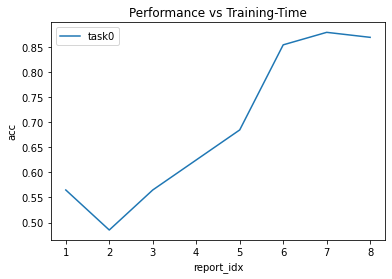

INFO:root:Training completed. Auto-saving to "./ag_sst/". For loading the model, you can use `predictor = TextPredictor.load("./ag_sst/")`


In [3]:
from autogluon.text import TextPredictor

predictor = TextPredictor(label='label', eval_metric='acc', path='./ag_sst')
predictor.fit(train_data, time_limit=60)

## Evaluation

After training, we can easily evaluate our predictor on separate test data formatted similarly to our training data.

In [4]:
test_score = predictor.evaluate(test_data)
print('Accuracy = {:.2f}%'.format(test_score * 100))

Accuracy = 89.33%


By default, `evaluate()` will report the evaluation metric previously specified, which is `accuracy` in our example. You may also specify additional metrics, e.g. F1 score, when calling evaluate.

In [5]:
test_score = predictor.evaluate(test_data, metrics=['acc', 'f1'])
print(test_score)

{'acc': 0.893348623853211, 'f1': 0.8937142857142857}


# Prediction

And you can easily obtain predictions from these models by calling `predictor.predict()`.

In [6]:
sentence1 = "it's a charming and often affecting journey."
sentence2 = "It's slow, very, very, very slow."
predictions = predictor.predict({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Predicted Sentiment":', predictions[1])

"Sentence": it's a charming and often affecting journey. "Predicted Sentiment": 1
"Sentence": It's slow, very, very, very slow. "Predicted Sentiment": 0


For classification tasks, you can ask for predicted class-probabilities instead of predicted classes.

In [7]:
probs = predictor.predict_proba({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Class-Probabilities":', probs[0])
print('"Sentence":', sentence2, '"Predicted Class-Probabilities":', probs[1])

"Sentence": it's a charming and often affecting journey. "Predicted Class-Probabilities": 0    0.012671
1    0.888297
Name: 0, dtype: float32
"Sentence": It's slow, very, very, very slow. "Predicted Class-Probabilities": 0    0.987329
1    0.111703
Name: 1, dtype: float32


We can just as easily produce predictions over an entire dataset.

In [8]:
test_predictions = predictor.predict(test_data)
test_predictions.head()

0    1
1    0
2    1
3    1
4    0
Name: label, dtype: int64

## Intermediate Training Results

After training, you can explore intermediate training results in `predictor.results`.

In [9]:
predictor.results.tail(3)

,iteration,report_idx,epoch,f1,mcc,roc_auc,accuracy,log_loss,find_better,find_new_topn,nbest_stat,elapsed_time,reward_attr,eval_metric,exp_dir
6,14,7,1,0.899160,0.757789,0.931441,0.88,0.330533,True,True,"[[0.685, 0.88, 0.855], [10, 14, 12]]",49,0.88,accuracy,/home/ec2-user/SageMaker/ag_sst/task0
7,16,8,2,0.886957,0.734739,0.943953,0.87,0.344672,False,True,"[[0.87, 0.88, 0.855], [16, 14, 12]]",54,0.87,accuracy,/home/ec2-user/SageMaker/ag_sst/task0
8,14,9,1,0.899160,0.757789,0.931441,0.88,0.330533,True,True,"[[0.685, 0.88, 0.855], [10, 14, 12]]",49,0.88,accuracy,/home/ec2-user/SageMaker/ag_sst/task0


## Save and Load

The trained predictor is automatically saved at the end of `fit()`, and you can easily reload it.

In [10]:
loaded_predictor = TextPredictor.load('ag_sst')
loaded_predictor.predict_proba({'sentence': [sentence1, sentence2]})

,0,1
0,0.012671,0.987329
1,0.888297,0.111703


You can also save the predictor to any location by calling `.save()`.

In [11]:
loaded_predictor.save('my_saved_dir')
loaded_predictor2 = TextPredictor.load('my_saved_dir')
loaded_predictor2.predict_proba({'sentence': [sentence1, sentence2]})

,0,1
0,0.012671,0.987329
1,0.888297,0.111703


## Extract Embeddings

You can also use a trained predictor to extract embeddings that maps each row of the data table to an embedding vector extracted from intermediate neural network representations of the row.

In [12]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings)

[[-0.01822774 -0.06155895  0.13436177 ... -0.4454752   0.537465
   0.38984144]
 [-0.14591864  0.5322923   0.29201877 ... -0.01443126  0.28827152
   0.37132087]
 [ 0.19060715  0.12236104  0.52053577 ... -0.3293577   0.46647763
   0.4387398 ]
 ...
 [ 0.24332397  0.15041006  0.46015418 ... -0.17658648  0.19947228
   0.53865325]
 [ 0.48942107  0.3673211   0.00752563 ... -0.02179538  0.13347624
   0.3706505 ]
 [-0.16765167  0.37639114  0.31317368 ... -0.40672117  0.11371957
   0.3579047 ]]


Here, we use TSNE to visualize these extracted embeddings. We can see that there are two clusters corresponding to our two labels, since this network has been trained to discriminate between these labels.

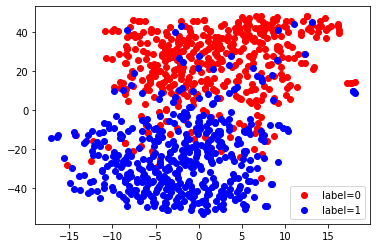

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
for val, color in [(0, 'red'), (1, 'blue')]:
    idx = (test_data['label'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
plt.legend(loc='best')